# Modelisation de la consommation totale d'energie

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.preprocessing as sk_prepro
from sklearn import metrics

In [2]:
df = pd.read_csv('data_full.csv')

In [3]:
data_num = df
target_tag = 'SiteEUI(kBtu/sf)'
target = data_num[target_tag]
data_num = data_num.drop(labels = [target_tag, 'TotalGHGEmissions', 'ENERGYSTARScore','SiteEnergyUse(kBtu)'], axis = 1)

In [4]:
data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1634 entries, 0 to 1633
Columns: 573 entries, 0 to ThirdLargestPropertyUseTypeGFA
dtypes: float64(573)
memory usage: 7.1 MB


## Modèle linéaire

In [5]:
from sklearn.linear_model import Ridge
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor

In [6]:
#first let's test this on knregressoe
xtrain, xtest, ytrain, ytest = train_test_split(data_num, target, test_size = 0.2)

#let's standard scale

sscaler = sk_prepro.StandardScaler()
sscaler_fit = sscaler.fit(xtrain)
xtrain = sscaler_fit.transform(xtrain)
xtest = sscaler_fit.transform(xtest)

#let's grid search for the k

k_grid = {'n_neighbors' : list(range(2,16))}
score = 'r2'

reg = GridSearchCV(KNeighborsRegressor(), k_grid, cv =3, scoring = score, verbose = 1)

reg.fit(xtrain, ytrain)

print('Best params on training set : {}'.format(reg.best_params_))

print('GridCV results : ')
for mean, std, k in zip(reg.cv_results_['mean_test_score'],
                       reg.cv_results_['std_test_score'],
                       reg.cv_results_['params']):
    print('{} = {:.3f} (+/- {:.3f}) for {}'.format(score,mean,std*2,k))

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Best params on training set : {'n_neighbors': 6}
GridCV results : 
r2 = 0.088 (+/- 0.054) for {'n_neighbors': 2}
r2 = 0.175 (+/- 0.061) for {'n_neighbors': 3}
r2 = 0.216 (+/- 0.113) for {'n_neighbors': 4}
r2 = 0.225 (+/- 0.141) for {'n_neighbors': 5}
r2 = 0.229 (+/- 0.173) for {'n_neighbors': 6}
r2 = 0.228 (+/- 0.167) for {'n_neighbors': 7}
r2 = 0.225 (+/- 0.163) for {'n_neighbors': 8}
r2 = 0.216 (+/- 0.169) for {'n_neighbors': 9}
r2 = 0.213 (+/- 0.165) for {'n_neighbors': 10}
r2 = 0.213 (+/- 0.160) for {'n_neighbors': 11}
r2 = 0.211 (+/- 0.160) for {'n_neighbors': 12}
r2 = 0.203 (+/- 0.153) for {'n_neighbors': 13}
r2 = 0.199 (+/- 0.143) for {'n_neighbors': 14}
r2 = 0.194 (+/- 0.133) for {'n_neighbors': 15}


In [7]:
from sklearn import linear_model
line_reg = linear_model.LinearRegression()

In [8]:
def true_pred_plot(y_train,pred_train, y_test, pred_test):
    fig, ax = plt.subplots(2, figsize = (10,10))
    
    line_reg_train = line_reg.fit(np.array(pred_train).reshape(-1,1),y_train)
    r2_train = line_reg_train.score(np.array(pred_train).reshape(-1,1),y_train)
    rmse_train = (np.sqrt(metrics.mean_squared_error(y_train, pred_train))/np.mean(ytrain))
    a = float(line_reg_train.coef_)
    b= line_reg_train.intercept_
    ax[0].scatter( y_train, pred_train)
    ax[0].plot([a*np.abs(b)+b, a*y_train.max()+b],[np.abs(b), ytrain.max()], linestyle = 'dashed')
    ax[0].text(0.7,0.7,'R2 : {:.3f} NRMSE : {: .2f}'.format(r2_train,rmse_train), transform = ax[0].transAxes)
    ax[0].set_xlabel('True values')
    ax[0].set_ylabel('Predicted values')
    ax[0].set_xlim(-10,y_train.max())
    ax[0].set_ylim(-10,pred_train.max())
    ax[0].set_title('On train values')

    line_reg_test  = line_reg.fit(np.array(pred_test).reshape(-1,1),y_test)
    r2_test =  line_reg_test.score(np.array(pred_test).reshape(-1,1),y_test)
    rmse_test = (np.sqrt(metrics.mean_squared_error(y_test, pred_test))/np.mean(ytest))
    a = float(line_reg_test.coef_)
    b=  line_reg_test.intercept_
    ax[1].scatter( y_test, pred_test)
    ax[1].plot([a*np.abs(b)+b, a*y_test.max()+b],[np.abs(b), y_test.max()], linestyle = 'dashed')
    ax[1].text(0.7,0.7,'R2 : {:.3f} NRMSE : {: .2f}'.format(r2_test, rmse_test), transform = ax[1].transAxes)
    ax[1].set_xlabel('True values')
    ax[1].set_ylabel('Predicted values')
    ax[1].set_xlim(-10,y_test.max())
    ax[1].set_ylim(-10,pred_test.max())
    ax[1].set_title('On test values')
    
    plt.show()
    plt.clf()

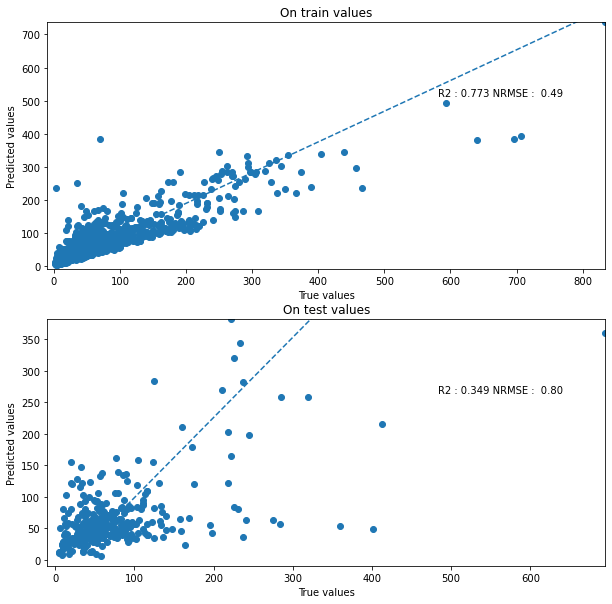

<Figure size 432x288 with 0 Axes>

In [9]:
model = KNeighborsRegressor(n_neighbors=2).fit(xtrain, ytrain)

true_pred_plot(ytrain, model.predict(xtrain), ytest, model.predict(xtest))

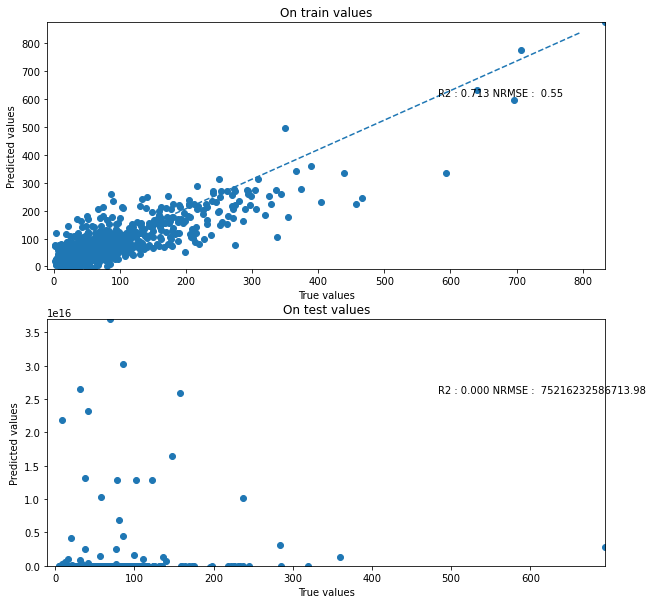

<Figure size 432x288 with 0 Axes>

In [10]:
line_reg_m = linear_model.LinearRegression()

line_reg_m.fit(xtrain,ytrain)


true_pred_plot(ytrain, line_reg_m.predict(xtrain), ytest, line_reg_m.predict(xtest))

In [11]:
print(ytest.max()/1000000, line_reg_m.predict(xtest).max()/1000000)

0.0006947000121999999 37036273666.90207


In [12]:
#let's try with a svr
C_range = [1.0, 5.0, 10.0, 100.0]
kernels = ['linear', 'rbf', 'sigmoid', 'poly']
degrees = [2,3,4]
gamma_range  = np.logspace(-2, 1, 10)
#gamma_range = np.logspace(-2, 1, 10)
#'gamma' : gamma_range
param_grid = {'gamma' : gamma_range, 'kernel' : kernels, 'degree' : degrees, 'C' : C_range}

score = 'neg_mean_squared_error'

svr_cv = GridSearchCV(svm.SVR(), param_grid, cv = 3, scoring = score, verbose = 1)

svr_cv.fit(xtrain, ytrain)

print('Best params on training set : {}'.format(svr_cv.best_params_))

Fitting 3 folds for each of 480 candidates, totalling 1440 fits



KeyboardInterrupt



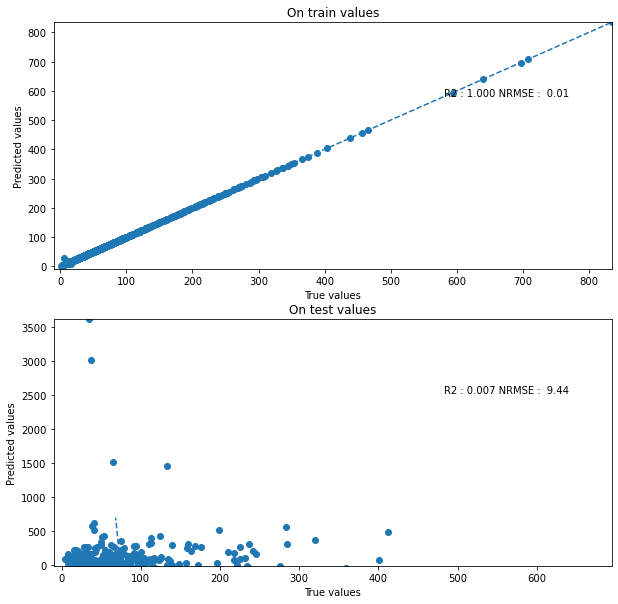

<Figure size 432x288 with 0 Axes>

In [13]:
svr = svm.SVR(kernel="poly", C=10.0, gamma = 2.15, degree = 3)
svr = svr.fit(xtrain,ytrain)

true_pred_plot(ytrain, svr.predict(xtrain), ytest, svr.predict(xtest))

In [15]:
from sklearn import kernel_ridge
#let's try with a ridge regression


alpha_range = [1.0, 5.0, 10.0, 100.0]
kernels = ['linear', 'poly', 'sigmoid', 'rbf']
degrees = [3,4,5]
gamma_range  = np.logspace(-2, 1, 10)


param_grid = {'gamma' : gamma_range, 'kernel' : kernels, 'degree' : degrees, 'alpha' : alpha_range}

score = 'neg_mean_absolute_percentage_error'

kernel_ridge_cv = GridSearchCV(kernel_ridge.KernelRidge(), param_grid, cv = 3, scoring = score, verbose = 1)

kernel_ridge_cv.fit(xtrain, ytrain)

print('Best params on training set : {}'.format(kernel_ridge_cv.best_params_))

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_mo

Best params on training set : {'alpha': 100.0, 'degree': 4, 'gamma': 0.01, 'kernel': 'poly'}


In [14]:
model = kernel_ridge.KernelRidge(alpha = 1.0, kernel = 'poly', degree = 3, gamma = 0.01)
model = model.fit(xtrain, ytrain)

true_pred_plot(ytrain, model.predict(xtrain), ytest, model.predict(xtest))

NameError: name 'kernel_ridge' is not defined

## Neural network

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
#test with a single perceptron
model = keras.Sequential()
model.add(keras.Input(shape = xtrain.shape[1]))
model.add(layers.Dense(1,input_dim = 2, activation = 'linear'))

model.compile(metrics = [tf.keras.metrics.RootMeanSquaredError()], loss = 'mean_absolute_percentage_error', optimizer = 'adam')

model.summary()

In [ ]:
history = model.fit(xtrain, ytrain, epochs = 50, batch_size = 4, verbose = 1)

In [ ]:
#now with a multi layer network

model2 = keras.Sequential(
    [
        layers.Dense(xtrain.shape[1], activation="selu", name="layer1", input_shape=(xtrain.shape[1],), input_dim = 2),
        layers.Dense(383, activation="selu", name="layer2"),
        layers.Dense(287, activation="selu", name="layer2b"),
        layers.Dense(82, activation="selu", name="layer3"),
        layers.Dense(20, activation="selu", name="layer4"),
        layers.Dense(4, activation = "selu", name = "layer5"),
        layers.Dense(1, activation = 'linear', name="layer6"),
    ]
)

model2.compile(metrics = [tf.keras.metrics.RootMeanSquaredError()], loss = 'mean_absolute_percentage_error', optimizer = 'adam')

model2.summary()

history2 = model2.fit(xtrain, ytrain, epochs = 50, batch_size = 2, verbose = 1)

In [ ]:
model3 = keras.Sequential(
    [
        layers.Dense(xtrain.shape[1], activation="relu", name="layer1", input_shape=(xtrain.shape[1],), input_dim = 2),
        layers.Dense(287, activation="relu", name="layer2"),
        layers.Dense(1, activation = 'linear', name="layer3"),
    ]
)

model3.compile(metrics = [tf.keras.metrics.RootMeanSquaredError()], loss = 'mean_absolute_percentage_error', optimizer = 'adam')

model3.summary()

history3 = model3.fit(xtrain, ytrain, epochs = 50, batch_size = 2, verbose = 1)

In [ ]:
from sklearn.ensemble import RandomForestRegressor



In [ ]:
rfr = RandomForestRegressor(n_estimators=500, verbose = 1)

model = rfr.fit(xtrain,ytrain)

true_pred_plot(ytrain, model.predict(xtrain), ytest, model.predict(xtest))